### Import Necessary Libraries

In [1]:
import numpy as np, matplotlib.pyplot as plt
import random, operator

### Binary Run Length Encoding and Decoding

Assumes the first run is of the digit is 0

In [2]:
from itertools import groupby
def encode(input_string):
    return [(len(list(g))) for k,g in groupby(input_string)]
 
def decode(lst):
    b = ''.join('01'*(len(lst)/2))
    r = ''
    for i in range(len(lst)):
        r += lst[i] * b[i]
    return r

### Testing Encoding and Decoding Function

In [3]:
print(encode("000011101010010101110010101110001111111"))
print(decode([4, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 3, 7]))

[4, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 3, 7]
000011101010010101110010101110001111111


### Instantiate a Binary Matrix with random values

In [4]:
#Creates a binary matrix with size 'size' and probability of a 1 occuring as 'probability'
def create_matrix(size, probability): 
    return np.random.choice(a=[1, 0], size=(size, size), p=[probability, 1 - probability])

### Testing function

In [5]:
print(create_matrix(4, 0.5))

[[0 0 1 0]
 [1 0 1 0]
 [0 1 1 0]
 [1 0 1 1]]


### Fitness function counts the number of cells that will be alive in the next automata

In [154]:
def fitness(matrix, rule_list):
    matrix3 = margolus1(matrix, rule_list)
    return count_alive(matrix3)
    #return len(encode(''.join([str(i) for n in matrix3 for i in n])))

def margolus1(matrix, rule_list):
    matrix_size = len(matrix)
    matrix2 = matrix.copy()
    #print(matrix2)

    for x in range(0,matrix_size,2):
        for y in range(0,matrix_size,2):

            #Create a pointer for each 2x2 cell in the matrix. Nested array eg: [[0, 1], [1, 1]]
            square = matrix2[x:x+2,y:y+2]

            #Find the current configuration of the cell. an int ranging from 0 to 15. eg: 14
            config = int(''.join([str(j) for i in square for j in i][::-1]), 2)

            #Find config of the next gen of cell according to given RCA rule. an array  eg: [0, 1, 0, 1]
            values = [int(k) for k in str(bin(rule_list[config]))[:1:-1].ljust(4, '0')]

            #Set the new config for the cell eg: [[0, 1], [0, 1]] 
            square[0,0], square[0,1] = values[0], values[1]
            square[1,0], square[1,1] = values[2], values[3]

    return matrix2
    

def margolus2(matrix, rule_list):
    matrix2 = margolus_shift1(matrix)
    matrix2 = margolus1(matrix2, rule_list)
    return margolus_shift2(matrix2)

def margolus_shift1(matrix):
    shiftedup =  np.roll(matrix, -1, axis=0)
    shiftedleft = np.roll(shiftedup, -1, axis=1)
    return shiftedleft

def margolus_shift2(matrix):
    shiftedup =  np.roll(matrix, 1, axis=0)
    shiftedleft = np.roll(shiftedup, 1, axis=1)
    return shiftedleft

def count_alive(matrix):
    """Counts number of cells that will be alive in the next generation of cellular automata"""
    matrix3 = matrix.copy()
    matrix3 = margolus_shift1(matrix3)
    matrix_size = len(matrix)
    
    counter = 0
    for x in range(0,matrix_size,2):
        for y in range(0,matrix_size,2): #Starts the 2X2 box at 0,0 and then moves onto the next 2X2 box
            square = matrix3[x:x+2,y:y+2] #Creates a pointer to the 2X2 part of the dis
            #print("square = ", square)
            if 1 in square:
                counter += 1

    return counter

### Function to initialise population of rulesets with given size

In [8]:
def initialise_population(population_size):
    a=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    population = []
    
    for i in range(population_size):
        population.append(random.sample(a, len(a)))
    
    return population

### Testing function

In [9]:
print(initialise_population(10))

[[10, 1, 0, 6, 8, 15, 2, 11, 12, 5, 14, 9, 7, 3, 4, 13], [2, 15, 9, 1, 0, 11, 7, 10, 13, 8, 14, 3, 5, 4, 6, 12], [14, 9, 8, 12, 3, 4, 1, 6, 0, 7, 15, 5, 10, 2, 13, 11], [6, 0, 8, 5, 10, 9, 15, 11, 13, 1, 3, 7, 2, 12, 14, 4], [15, 4, 11, 2, 7, 5, 1, 0, 10, 3, 14, 9, 13, 6, 8, 12], [7, 1, 13, 10, 8, 15, 2, 5, 11, 14, 6, 0, 4, 3, 9, 12], [1, 12, 9, 7, 14, 2, 8, 15, 6, 11, 0, 5, 4, 3, 13, 10], [13, 1, 9, 14, 11, 0, 2, 5, 6, 12, 15, 10, 7, 4, 8, 3], [2, 10, 1, 13, 5, 6, 0, 9, 14, 15, 7, 3, 12, 11, 8, 4], [12, 8, 0, 15, 9, 4, 13, 10, 2, 1, 14, 5, 7, 3, 6, 11]]


## Create the Genetic Algorithm
Guide: https://github.com/ezstoltz/genetic-algorithm/blob/master/genetic_algorithm_TSP.ipynb


Rank individual chromosomes

In [70]:
def rank_population(matrix, population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = fitness(matrix.copy(), population[i])
    
    sorted_fitness = sorted(fitnessResults.items(), key = operator.itemgetter(1))
    best = sorted_fitness[0][0]
    #print "Best Chromosome: ", population[best], sorted_fitness[0]
    #print "Best Chromosome: ", sorted_fitness[0]
    
    ranked_population = []

    for i in sorted_fitness:
        index = i[0]
        ranked_population.append(population[index])
            
    return ranked_population, sorted_fitness[0][1], population[best]

### Testing function

In [71]:
pop = initialise_population(population_size)
matrix = create_matrix(4, 0.5)
ranked, best, bestch = rank_population(matrix, pop)
#print(ranked)
print(best, bestch)

(2, [7, 5, 14, 9, 12, 10, 15, 0, 6, 3, 1, 4, 13, 8, 2, 11])


### Partially Matched Crossover Breeding Function

In [12]:
def breed(parent1, parent2):
    """Return a new chromosome created via partially matched crossover (PMX).
    This is suitable for permutation encoded GAs. Partially matched crossover
    respects the absolute position of alleles.
    Args:
        parent1 (List): A parent chromosome.
        parent2 (List): A parent chromosome.
    Returns:
        List[List]: Two new chromosomes descended from the given parents.
    Source:
        https://github.com/rawg/levis/blob/master/levis/crossover.py#L271
    """
    third = len(parent1) // 3
    l1 = int(random.triangular(1, third, third * 2))
    l2 = int(random.triangular(third, third * 2, len(parent1) - 1))

    if l2 < l1:
        l1, l2 = l2, l1

    def pmx(parent1, parent2):
        matching = parent2[l1:l2]
        displaced = parent1[l1:l2]
        child = parent1[0:l1] + matching + parent1[l2:]

        tofind = [item for item in displaced if item not in matching]
        tomatch = [item for item in matching if item not in displaced]

        for k, v in enumerate(tofind):
            subj = tomatch[k]
            locus = parent1.index(subj)
            child[locus] = v

        return child

    #print "Parents ", parent1, "and ", parent2, "breeded ", pmx(parent1, parent2)
    return [pmx(parent1, parent2), pmx(parent2, parent1)]

### Create mating pool and breed

In [13]:
def mating_pool(ranked_population, elite_size):
    
    elite_size = int(len(ranked_population) * elite_size)
    elite = ranked_population[0:elite_size]
    
    breeders_size = int(len(ranked_population)/(2 *elite_size))
    breeders = ranked_population[0:breeders_size]
    
    #print elite_size
    #print breeders_size
    
    children = []
    
    for parent1 in elite:
        for parent2 in breeders:
            offsprings = breed(parent1, parent2)
            children.extend(offsprings)
            
    #children.extend(initialise_population(500))
    return children

### Testing function

In [14]:
mating_pool(ranked, 0.01)

[[12, 7, 3, 10, 1, 9, 0, 6, 4, 8, 5, 14, 15, 13, 2, 11],
 [12, 7, 3, 10, 1, 9, 0, 6, 4, 8, 5, 14, 15, 13, 2, 11],
 [12, 7, 1, 9, 6, 3, 10, 13, 11, 8, 5, 14, 15, 0, 2, 4],
 [13, 12, 14, 2, 1, 9, 0, 6, 4, 3, 5, 11, 8, 10, 15, 7],
 [0, 7, 3, 10, 9, 2, 12, 8, 4, 6, 5, 14, 15, 13, 1, 11],
 [15, 3, 2, 4, 1, 9, 0, 6, 12, 14, 13, 5, 7, 11, 10, 8],
 [12, 7, 3, 10, 0, 9, 1, 5, 8, 4, 6, 14, 15, 13, 2, 11],
 [12, 14, 15, 9, 1, 3, 0, 6, 4, 10, 13, 2, 7, 8, 11, 5],
 [12, 7, 3, 10, 1, 11, 6, 0, 4, 8, 5, 14, 15, 13, 2, 9],
 [12, 15, 3, 7, 11, 9, 0, 8, 2, 10, 14, 1, 4, 6, 13, 5],
 [12, 7, 0, 5, 15, 6, 13, 9, 3, 4, 8, 14, 10, 1, 2, 11],
 [3, 14, 7, 10, 1, 9, 0, 6, 4, 8, 5, 13, 12, 2, 15, 11],
 [12, 8, 15, 14, 10, 2, 7, 6, 4, 13, 0, 1, 3, 5, 9, 11],
 [14, 11, 3, 10, 1, 9, 0, 6, 4, 8, 5, 13, 12, 7, 15, 2],
 [12, 9, 1, 5, 3, 7, 0, 13, 8, 4, 10, 14, 15, 6, 2, 11],
 [12, 2, 3, 10, 1, 9, 0, 6, 4, 5, 14, 11, 13, 7, 8, 15],
 [12, 7, 8, 2, 3, 14, 6, 0, 4, 10, 5, 9, 15, 13, 1, 11],
 [13, 2, 3, 10, 1, 9, 0, 4, 11,

### Create function to mutate a single chromosome

In [15]:
def mutate(ruleset, probability):
    """Return a mutated chromosome made through swap mutation.
    This chooses two random points in a list and swaps their values. It is
    suitable for use with list, value, and permutation encoding, but designed
    for the latter.
    Args:
        chromosome (List): The source chromosome for mutation.
        probability (float): The mutation rate or the probability that an
            allele will be mutated.
    Returns:
        List: A mutant chromosome.
    Source:
        https://github.com/rawg/levis/blob/master/levis/mutation.py#L75
    """
    
    probability /= 14 #Added this line later given difference between given and actual mutation rate
    mutant = list(ruleset)
    changes = 0
    offset = probability

    for locus1 in range(0, len(ruleset)):
        if random.random() < offset:
            locus2 = locus1
            while locus2 == locus1:
                locus2 = random.randint(0, len(ruleset) - 1)

            mutant[locus1], mutant[locus2] = mutant[locus2], mutant[locus1]
            changes += 2
            offset = probability / changes

    return mutant

### Testing function

In [16]:
counter = 0
mutation_rate = 0.02
for i in range(1000):
    rule = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    if mutate(rule, mutation_rate) != rule:
        counter += 1

print("Given Mutation Rate: ", mutation_rate)
print("Actual Mutation Rate: ", counter/1000.0)

('Given Mutation Rate: ', 0.02)
('Actual Mutation Rate: ', 0.022)


### Create function to mutate population based on mutation rate

In [17]:
def mutate_population(population, mutation_rate):
    mutated_population = []
    
    #print "size of population to mutate: ", len(population)
    for ruleset in range(0, len(population)):
        mutated_ruleset = mutate(population[ruleset], mutation_rate)
        mutated_population.append(mutated_ruleset)
    return mutated_population

### Put all steps together to create the next generation

In [74]:
def next_generation(matrix, population, elite_size, mutation_rate):
    ranked_population, best_fitness, best_chromosome = rank_population(matrix, population)
    children = mating_pool(ranked_population, elite_size)
    next_gen = mutate_population(children, mutation_rate)
    return next_gen, best_fitness, best_chromosome

### Final step: create the genetic algorithm

In [38]:
def genetic_algorithm(matrix_size, population_size, elite_size, mutation_rate, generations):
    matrix = create_matrix(matrix_size, 0.5)
    population = initialise_population(population_size)

    for i in range(0, generations):
        population, best_fitness = next_generation(matrix, population, elite_size, mutation_rate)

    return best_fitness#, count_alive(matrix)-best_fitness

### Testing genetic algorithm

In [39]:
genetic_algorithm(10, population_size, elite_size, mutation_rate, 6)

15

## Function to plot the progress of the Genetic Algorithm

In [122]:
def genetic_algorithm_plot(matrix_size, population_size, elite_size, mutation_rate, generations):
    matrix = create_matrix(matrix_size, 0.5)
    population = initialise_population(population_size)
    progress = []

    for i in range(0, generations):
        population, best_fitness, best_chromosome = next_generation(matrix, population, elite_size, mutation_rate)
        progress.append(best_fitness)

    #plt.style.use('seaborn')
    plt.plot(progress)

    
    #plt.ylim(ymin=0)
    
    plt.ylabel('Number of cells alive')
    plt.xlabel('Generations')
    plt.show()
    
    return best_fitness, progress[0]-best_fitness

### Constants

In [6]:
matrix_size     = 10
population_size = 500
elite_size      = 0.02
mutation_rate   = 0.05

### Plot!

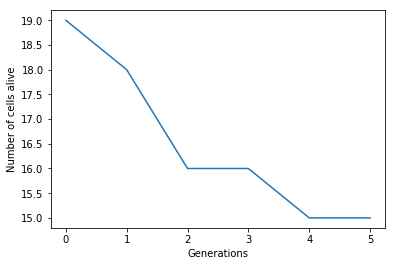

(15, 4)

In [134]:
genetic_algorithm_plot(10, 500, elite_size, mutation_rate, 6)

In [143]:
def genetic_algorithm_m(matrix, population_size, elite_size, mutation_rate, generations, supergeneration):
    population = initialise_population(population_size)
    progress = []
    
    for i in range(0, generations):
        population, best_fitness, best_chromosome = next_generation(matrix, population, elite_size, mutation_rate)
        progress.append(best_fitness)
        
    print best_chromosome
    
    if supergeneration%2:
        matrix = margolus1(matrix, best_chromosome)
    else:
        matrix = margolus2(matrix, best_chromosome)
    
    return matrix, best_fitness, progress

def iterative_genetic_algorithm(supergenerations):
    matrix = create_matrix(10, 0.5)
    print("Original length: ", len(''.join([str(i) for n in matrix for i in n])))
    print("Original RLE length: ", len(encode(''.join([str(i) for n in matrix for i in n]))))
    progress = []
    for supergeneration in range(0, supergenerations):
        matrix, best_fitness, midprogress = genetic_algorithm_m(matrix, 500, elite_size, mutation_rate, 6, supergeneration)
        #print(matrix)
        
        progress.extend(midprogress)
    
    print(progress)
    
    print("Final RLE length: ", len(encode(''.join([str(i) for n in matrix for i in n]))))
    
    plt.plot(progress)
    plt.ylabel('Number of cells alive')
    plt.xlabel('Generations')
    plt.show()

('Original length: ', 100)
('Original RLE length: ', 43)
[11, 8, 6, 0, 5, 9, 13, 12, 3, 4, 14, 1, 15, 10, 7, 2]
[13, 11, 12, 15, 14, 2, 9, 6, 7, 1, 3, 8, 4, 0, 5, 10]
[0, 11, 7, 2, 1, 12, 4, 8, 3, 9, 14, 13, 5, 10, 6, 15]
[0, 4, 9, 1, 3, 14, 8, 6, 5, 10, 7, 12, 2, 15, 13, 11]
[0, 9, 2, 3, 4, 15, 12, 7, 8, 1, 6, 14, 5, 11, 13, 10]
[18, 17, 15, 14, 14, 14, 19, 18, 15, 15, 15, 15, 18, 17, 16, 16, 15, 15, 17, 15, 14, 12, 12, 11, 15, 14, 13, 11, 11, 11]
('Final RLE length: ', 26)


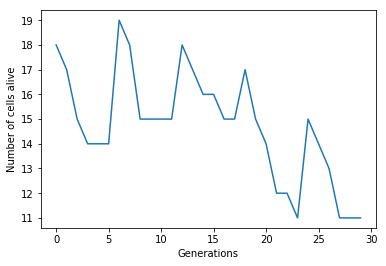

In [157]:
iterative_genetic_algorithm(5)

In [155]:
matrix = create_matrix(4, 0.5)
print(matrix)
print(margolus1(matrix, [6, 12, 14, 10, 13, 7, 0, 8, 5, 9, 11, 4, 3, 1, 15, 2]))
print(margolus2(matrix, [6, 12, 14, 10, 13, 7, 0, 8, 5, 9, 11, 4, 3, 1, 15, 2]))

[[1 0 0 0]
 [0 0 1 0]
 [1 0 1 1]
 [1 0 1 0]]
[[0 0 1 0]
 [1 1 1 1]
 [1 1 0 0]
 [1 0 0 1]]
[[1 1 1 0]
 [1 1 1 1]
 [0 0 1 0]
 [1 0 1 1]]


## Try to make a plot of matrix_size vs percent of cells shaved off

[10, 20, 30, 40, 50, 60, 70, 80, 90]


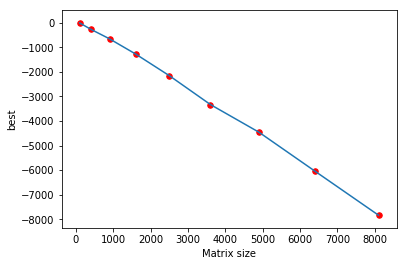

In [27]:
progress = []
r = range(10, 100, 10)
print(r)
for m_size in r:
    best, saved = genetic_algorithm(m_size, population_size, elite_size, mutation_rate, 5)
    progress.append(saved)

plt.plot([j**2 for j in r], [k*4 for k in progress])
plt.scatter([j**2 for j in r], [k*4 for k in progress], color='red', s=30)
plt.ylabel('best')
plt.xlabel('Matrix size')
plt.show()